### Exploratory Data Analysis of Group Psychotherapy Transcripts

- Joel Stremmel
- 11-20-23

##### About

This notebook explores group psychotherapy transcripts and survey data provided by Martin Kivlighan in the spring of 2023 and then again in the fall of 2023.  It describes:

- The survey response scores per session per participant
- The total number and distribution of words per session
- The number of words spoken by each speaker across sessions
- The number of words per speaker per session
- A heatmatrix of speaker mentions by other speakers
- The number of utterances/speaking turns per speaker per session
- The average sentiment per speaker per session normalized by the utterance lengths for Ekman's 6 basic emotions using a [pretrained sentiment classifier](https://huggingface.co/j-hartmann/emotion-english-roberta-large). 

##### Imports

In [1]:
import os
import re
import glob
import torch
import statistics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from pdfminer.high_level import extract_text
from transformers import AutoTokenizer, pipeline

##### Set Parameters

In [2]:
# Set sequence lengths for distribution plot and sentiment model
dist_max_seq_len = 32768
sent_max_seq_len = 512

# Set model/tokenizer paths
dist_tokenizer_path = "allenai/longformer-base-4096"
sent_model_path = "j-hartmann/emotion-english-roberta-large"

# Define data directory
pdf_dir = "./data/fall_2023/session_transcripts/"

# Define survey data path
survey_path = "./data/fall_2023/WDS_Session_Survey.xlsx"

# Group leaders
leaders_iter2 = [
    "Leader 1 (she/her)",
    "Leader 2 (she/her/hers)",
]

leaders_iter3 = [
    "Leader 1",
    "Leader 3"
]

# Define emotions used in sentiment model
emotions = ["neutral", "sadness", "surprise", "joy", "fear", "disgust", "anger"]

# Plot size
matplotlib.rcParams["figure.figsize"] = (9, 7)

# Set the default color cycle
CB_color_cycle = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
    "#000000",
    "#8DA0CB",
    "#A6D854",
    "#E5C494",
]
matplotlib.rcParams["axes.prop_cycle"] = matplotlib.cycler(color=CB_color_cycle)

##### Load Survey Data

In [3]:
df = pd.read_excel(survey_path)

##### Handle Nulls
For now, drop rows where the cohesion or Alliance rating is missing.

In [4]:
df = df[~df[['cohesion', 'Alliance']].isnull().any(axis=1)]

##### Fix Casing
There were some other typos of participants names in the Excel file that I manually fixed.

In [5]:
df['wdscode'] = df['wdscode'].apply(lambda x: x.capitalize())

##### Identify Participants

In [6]:
participant_text_names_iter2 = [x + '_2' for x in df[df['iteration'] == 2]['pseudonym'].unique()]

In [7]:
participant_text_names_iter2

['Betty_2',
 'Martha_2',
 'Sharon_2',
 'Cecilia_2',
 'Addison_2',
 'Gemma_2',
 'Bonnie_2',
 'Penny_2',
 'Tanya_2',
 'Maya_2']

In [8]:
participants_iter2 = df[df['iteration'] == 2]['wdscode'].unique().tolist()

In [9]:
participants_iter2

['Greendog6',
 'Bluecat11',
 'Purplepanda5',
 'Greenbird10',
 'Pinkrat9',
 'Greenpanda4',
 'Tealpika8',
 'Pinkelephant7',
 'Purplepangolin2',
 'Purpledolphin6']

In [10]:
participants_iter3 = df[df['iteration'] == 3]['wdscode'].unique().tolist()

In [11]:
participants_iter3

['Silverdog7',
 'Purplelion6',
 'Bluephoenix08',
 'Purpledog8',
 'Redmonkey7',
 'Greendino4',
 'Purpledragonfly9',
 'Dustyrosechihuahua5',
 'Rainbowwhale7']

##### Define Score and Text Dataframes from Surveys

In [12]:
score_df = df[
    ["wdscode",
     "pseudonym",
     "id",
     "iteration",
     "session",
     "cohesion",
     "Alliance"
    ]
]

text_df = df[["session", "id", "majortakeaway", "topicfdbk", "fdbkforleaders"]]

##### Sort Score Dataframe

In [13]:
iter2_score_df = score_df[score_df['iteration'] == 2].sort_values("session")
iter3_score_df = score_df[score_df['iteration'] == 3].sort_values("session")

In [14]:
iter2_score_df.shape

(67, 7)

In [15]:
iter3_score_df.shape

(65, 7)

##### Plot Scores per Participant per Session

In [16]:
def plot_scores_per_participant_per_session(score_df, participants, score_cols, identifier):
    
    # Check that score dataframe is sorted by session
    sessions = score_df["session"].tolist()
    assert_msg = "Expected score dataframe to be sorted by session."
    assert all(sessions[i] <= sessions[i + 1] for i in range(len(sessions) - 1)), assert_msg

    # Knowing the sessions are ordered, filter for each session ID for each participant
    # And plot the score per session per participant for all scores
    for score in score_cols:
        fig, ax = plt.subplots()
        for participant in participants:
            x = score_df[score_df[identifier] == participant]["session"].tolist()
            y = score_df[score_df[identifier] == participant][score].tolist()
            ax.plot(x, y, label=participant)

        # Set plot title and axis labels
        ax.set_title(f"Score - {score} - per Session per Participant")
        ax.set_xlabel("Session Number")
        ax.set_ylabel(f"Score - {score}")

        # Set legend
        ax.legend(fontsize=6, loc="best")

        # Show plot
        plt.show()

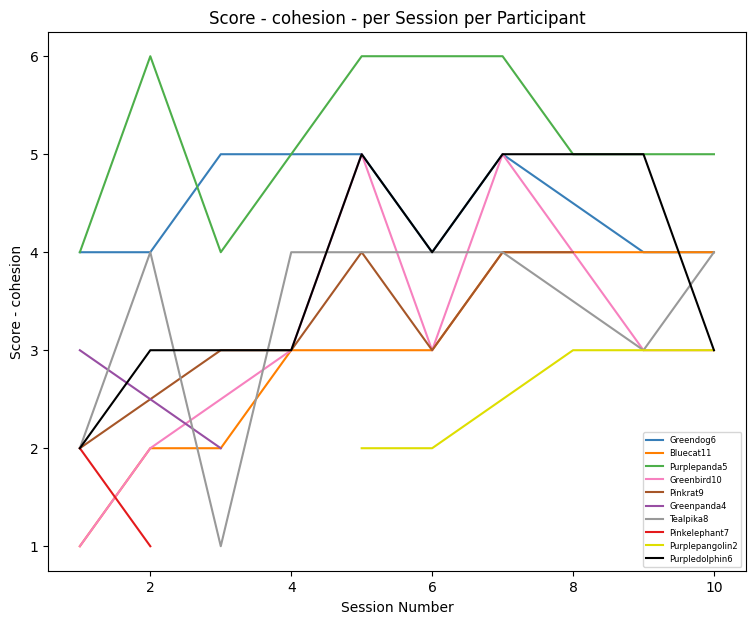

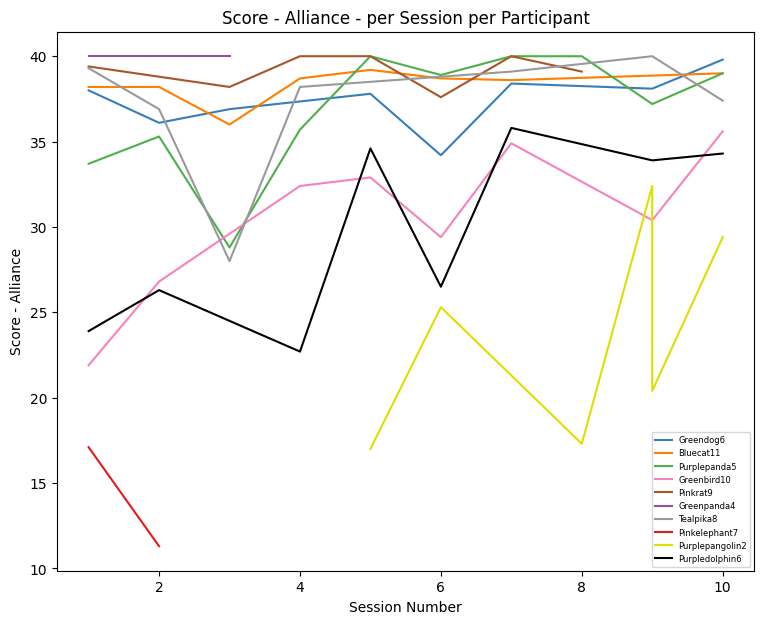

In [17]:
plot_scores_per_participant_per_session(
    score_df=iter2_score_df,
    participants=participants_iter2,
    score_cols=["cohesion", "Alliance"],
    identifier='wdscode'
)

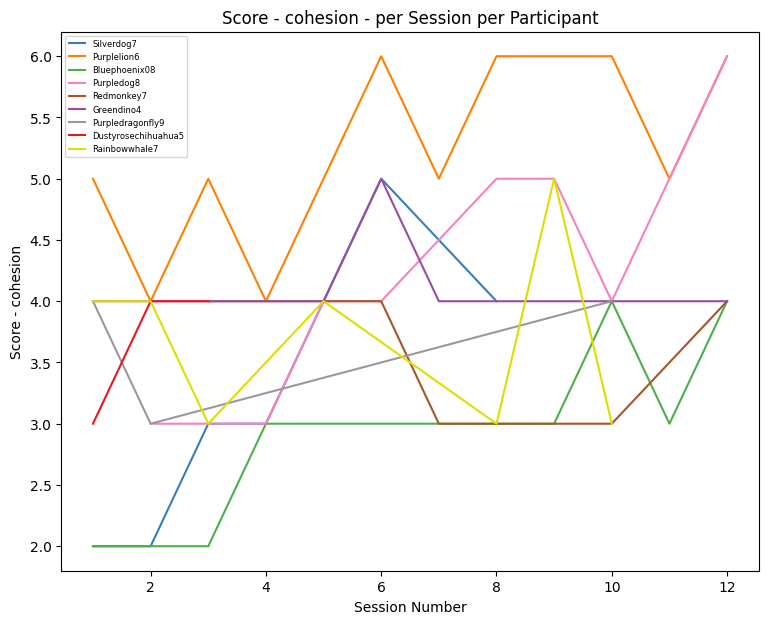

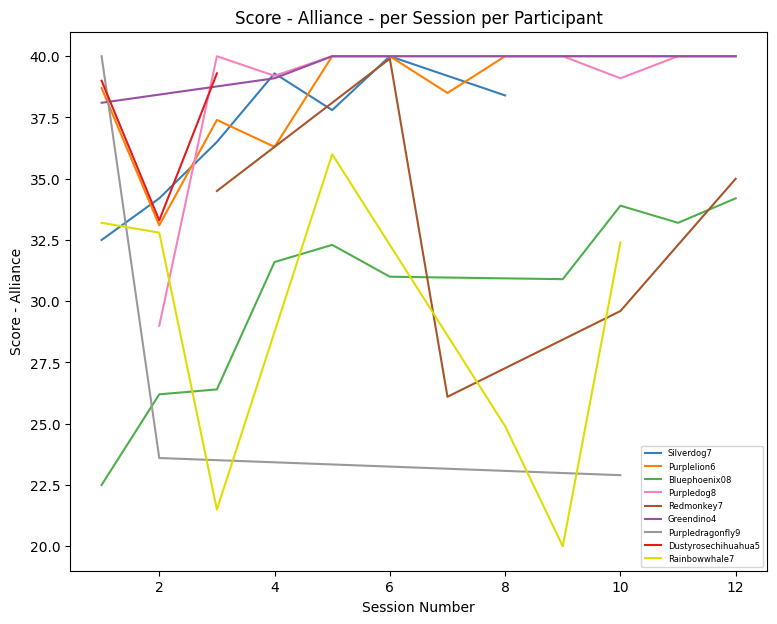

In [18]:
plot_scores_per_participant_per_session(
    score_df=iter3_score_df,
    participants=participants_iter3,
    score_cols=["cohesion", "Alliance"],
    identifier='wdscode'
)

##### Load Tokenizers

In [19]:
dist_tokenizer = AutoTokenizer.from_pretrained(dist_tokenizer_path)
sent_tokenizer = AutoTokenizer.from_pretrained(sent_model_path)

##### Load Sentiment Model

In [20]:
sent_pipeline = pipeline(
    "text-classification",
    model=sent_model_path,
    return_all_scores=True,
    truncation=True,
    max_length=sent_max_seq_len,
    top_k=None,
)

##### Collect PDFs of Transcripts

In [21]:
iter2_pdf_files = glob.glob(os.path.join(os.path.join(pdf_dir, 'WDS2'), "*.pdf"))
iter3_pdf_files = glob.glob(os.path.join(os.path.join(pdf_dir, 'WDS3'), "*.pdf"))

##### Extract PDF Text and Count Words

In [22]:
def count_words_in_pdfs(pdf_files):

    # Loop through each PDF file, convert to plain text, and count the number of words
    num_words_list = []
    num_subwords_list = []
    for pdf_file in pdf_files:
        text = extract_text(pdf_file)
        num_words = len(text.split())
        num_words_list.append(num_words)

        tokenized_text = dist_tokenizer(
            text, padding=False, truncation=True, max_length=dist_max_seq_len
        )
        num_subwords = len(tokenized_text["input_ids"])
        num_subwords_list.append(num_subwords)
        print(
            f"{pdf_file} - Number of words: {num_words} | Number of subwords: {num_subwords}"
        )

    # Calculate descriptive statistics
    mean_num_words = statistics.mean(num_words_list)
    std_num_words = statistics.stdev(num_words_list)
    mean_num_subwords = statistics.mean(num_subwords_list)
    std_num_subwords = statistics.stdev(num_subwords_list)

    # Print descriptive statistics
    print(f"\nNumber of documents: {len(num_words_list)}")
    print(f"Mean number of words per document: {mean_num_words:.2f}")
    print(f"Standard deviation of number of words per document: {std_num_words:.2f}")
    print(f"Mean number of subwords per document: {mean_num_subwords:.2f}")
    print(f"Standard deviation of number of subwords per document: {std_num_subwords:.2f}")

    # Generate histogram of  sequence lengths for all documents
    plt.hist(num_words_list, bins=10)
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.title("Number of Words Distribution")
    plt.show()

    plt.hist(num_subwords_list, bins=10)
    plt.xlabel("Number of Subwords")
    plt.ylabel("Frequency")
    plt.title("Number of Subwords Distribution")
    plt.show()

./data/fall_2023/session_transcripts/WDS2/WDS 2.8 Transcript.pdf - Number of words: 5275 | Number of subwords: 8417
./data/fall_2023/session_transcripts/WDS2/WDS 2.5 Transcript.pdf - Number of words: 6542 | Number of subwords: 10271
./data/fall_2023/session_transcripts/WDS2/WDS 2.3 Transcript.pdf - Number of words: 6635 | Number of subwords: 9359
./data/fall_2023/session_transcripts/WDS2/WDS 2.4 Transcript.pdf - Number of words: 6736 | Number of subwords: 10410
./data/fall_2023/session_transcripts/WDS2/WDS 2.6 Transcript.pdf - Number of words: 7322 | Number of subwords: 10626
./data/fall_2023/session_transcripts/WDS2/WDS 2.2 Transcript.pdf - Number of words: 6797 | Number of subwords: 9703
./data/fall_2023/session_transcripts/WDS2/WDS 2.7 Transcript.pdf - Number of words: 6506 | Number of subwords: 10102
./data/fall_2023/session_transcripts/WDS2/WDS 2.9 Transcript.pdf - Number of words: 6797 | Number of subwords: 10436
./data/fall_2023/session_transcripts/WDS2/WDS 2.10 Transcript.pdf -

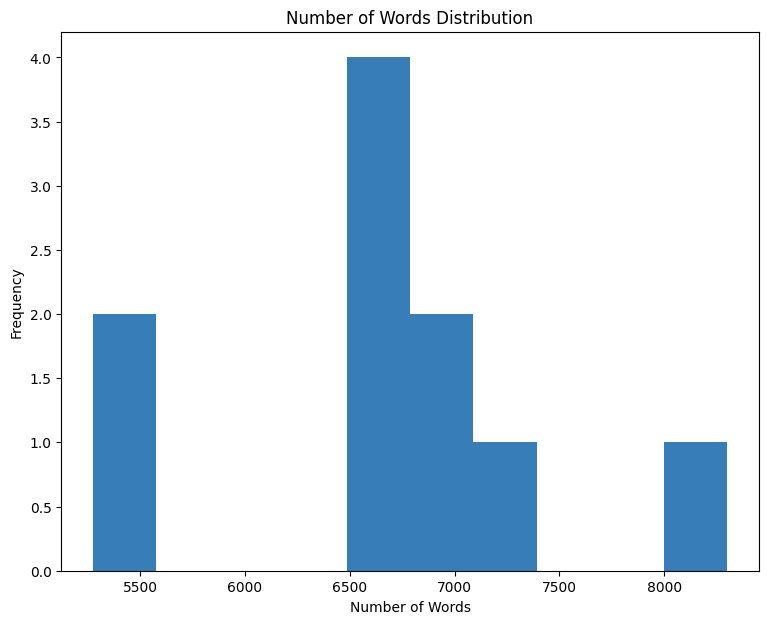

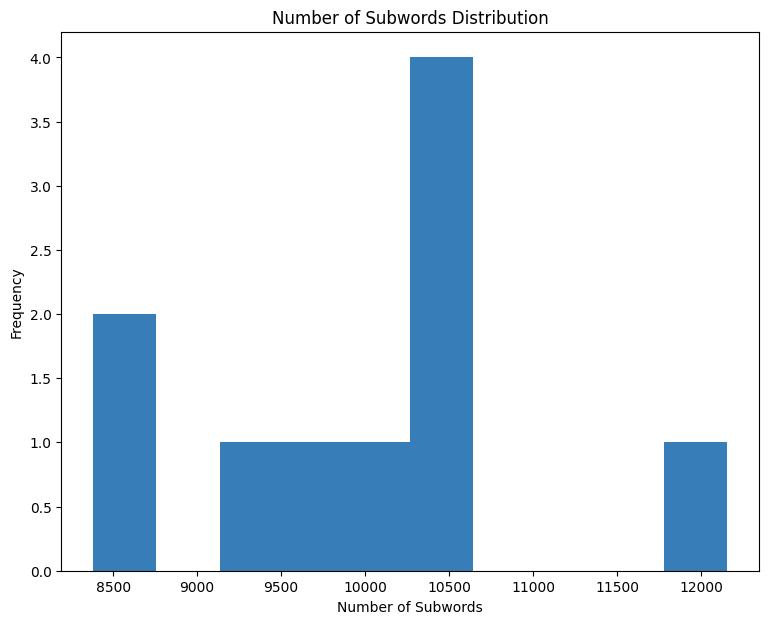

In [23]:
count_words_in_pdfs(iter2_pdf_files)

./data/fall_2023/session_transcripts/WDS3/WDS 3.11 Transcript.pdf - Number of words: 9419 | Number of subwords: 12957
./data/fall_2023/session_transcripts/WDS3/WDS 3.12 Transcript.pdf - Number of words: 9173 | Number of subwords: 13112
./data/fall_2023/session_transcripts/WDS3/WDS 3.3 Transcript.pdf - Number of words: 7438 | Number of subwords: 10800
./data/fall_2023/session_transcripts/WDS3/WDS 3.6 Transcript.pdf - Number of words: 8662 | Number of subwords: 12232
./data/fall_2023/session_transcripts/WDS3/WDS 3.10 Transcript.pdf - Number of words: 9442 | Number of subwords: 13502
./data/fall_2023/session_transcripts/WDS3/WDS 3.2 Transcript.pdf - Number of words: 9062 | Number of subwords: 12501
./data/fall_2023/session_transcripts/WDS3/WDS 3.4 Transcript.pdf - Number of words: 8798 | Number of subwords: 12812
./data/fall_2023/session_transcripts/WDS3/WDS 3.7 Transcript.pdf - Number of words: 9411 | Number of subwords: 13561
./data/fall_2023/session_transcripts/WDS3/WDS 3.8 Transcript.

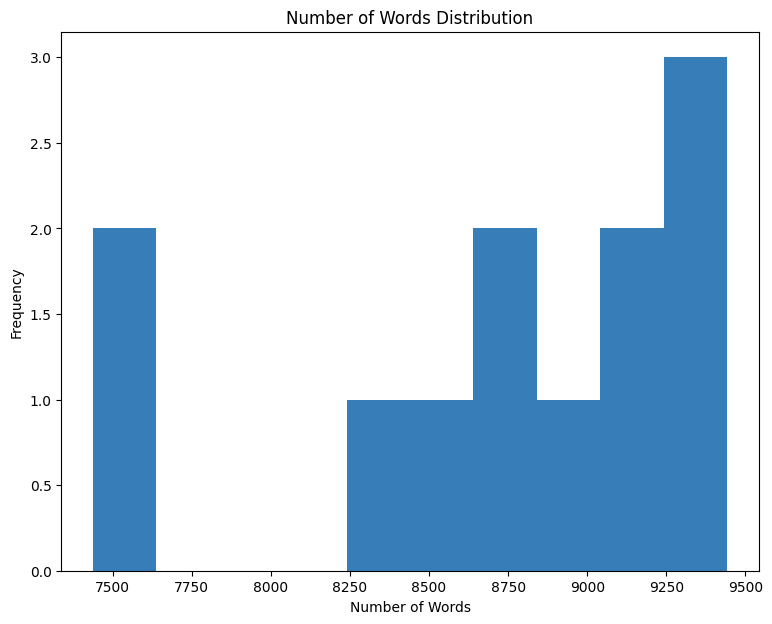

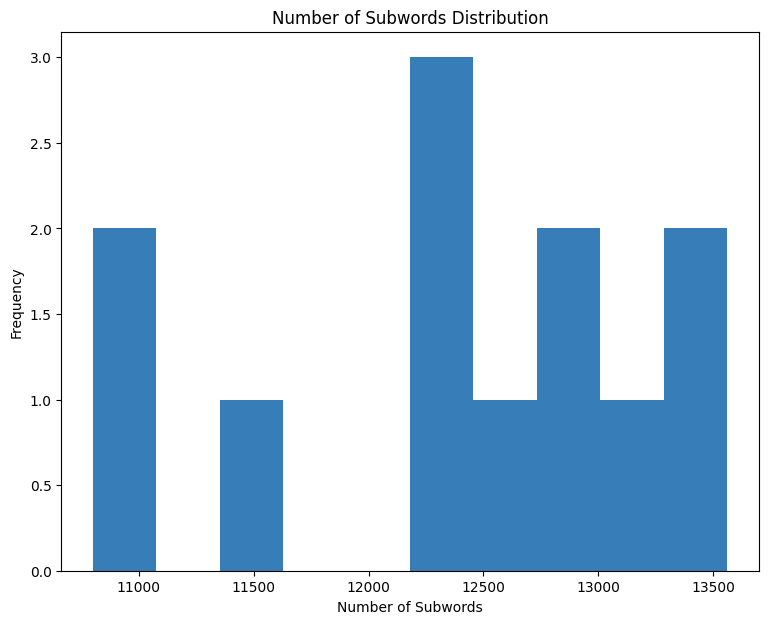

In [24]:
count_words_in_pdfs(iter3_pdf_files)

##### Define Function to Remove Lines

In [25]:
def should_remove(line):
    line = line.strip()
    if line.isdigit() or not line or (line.startswith("{") and line.endswith("}")) or 'WDS Iteration' in line:
        return True

##### Extract Text and Count Words per Speaker

In [26]:
def count_words_per_speaker(pdf_files, speakers):

    # Save total word counts, speaker word counts, mentions of, and complete utterances
    word_counts = {}
    speaker_word_counts = {}
    speaker_mentions_of = {
        speaker: {spoken_to: 0 for spoken_to in speakers} for speaker in speakers
    }
    speaker_utterances = {
        speaker: {num: [] for num in range(len(pdf_files))} for speaker in speakers
    }

    # Iterate through files to extract words
    for i, file in enumerate(pdf_files):
        # Reset speaker counts for new file
        speaker_counts = {}

        # Reset current speaker
        current_speaker = None

        # Reset utterance
        utterance = ""

        # Extract text
        text = extract_text(file)

        # Iterate through text split on double new lines
        for line in text.split("\n"):

            # If the line is blank, keep going
            if not line:
                continue

            # Check if one of the speakers is speaking
            for speaker in speakers:
                if line.startswith(speaker + ":"):
                    # If the current speaker is the same as this speaker, keep going
                    if current_speaker == speaker:
                        break

                    # Otherwise, we have a new speaker and we want to save the full utterance
                    # from the previous speaker, set the new speaker, and reset the utterance
                    # If the current speaker is None, it's our first iteration and there's
                    # Nothing to save
                    else:
                        if current_speaker is None:
                            assert utterance == "", "Expected utterance to be empty."
                        else:
                            speaker_utterances[current_speaker][i].append(utterance)
                        current_speaker = speaker
                        utterance = ""

            # If we have a current speaker, count the number of words in the line
            if current_speaker:
                # Handle empty lines, bracketted info, and page numbers
                if should_remove(line):
                    continue

                # Remove the speaker name from the line
                # Split on any number of whitespaces to define the words in the line
                clean_line = line.replace(current_speaker + ":", "")

                # Identify mentions of other speakers
                for speaker in speakers:
                    if f"[{speaker}]" in clean_line or f"{speaker}" in clean_line:
                        speaker_mentions_of[current_speaker][speaker] += 1

                # Get words
                words = clean_line.split()

                # Count the number of words in the line
                num_words = len(words)

                # Save the word counts
                if current_speaker in speaker_counts:
                    speaker_counts[current_speaker] += num_words
                else:
                    speaker_counts[current_speaker] = num_words

                # Add to the utterance which will contain words seperated only by single spaces
                utterance += " ".join(clean_line.split())

        # Track the total number of words spoken in the file by summing the words from each speaker
        word_counts[file] = sum(speaker_counts.values())

        # Track the total number of words spoken by each speaker across documents
        for speaker in speakers:
            if speaker in speaker_counts:
                if speaker in speaker_word_counts:
                    speaker_word_counts[speaker] += speaker_counts[speaker]
                else:
                    speaker_word_counts[speaker] = speaker_counts[speaker]


    mean_num_words = statistics.mean(word_counts.values())
    std_num_words = statistics.stdev(word_counts.values())

    print(f"\nNumber of documents: {len(word_counts)}")
    print(f"Mean number of words per document: {mean_num_words:.2f}")
    print(f"Standard deviation of number of words per document: {std_num_words:.2f}")

    # Note that because we strip text not directly associated with a speaker, 
    # the counts differ slightly from above
    plt.hist(word_counts.values(), bins=10)
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.title("Number of Words Distribution")
    plt.show()

    return speaker_word_counts, speaker_mentions_of, speaker_utterances

##### Check Transcript Words Distribution for Iteration 2


Number of documents: 10
Mean number of words per document: 6425.40
Standard deviation of number of words per document: 832.51


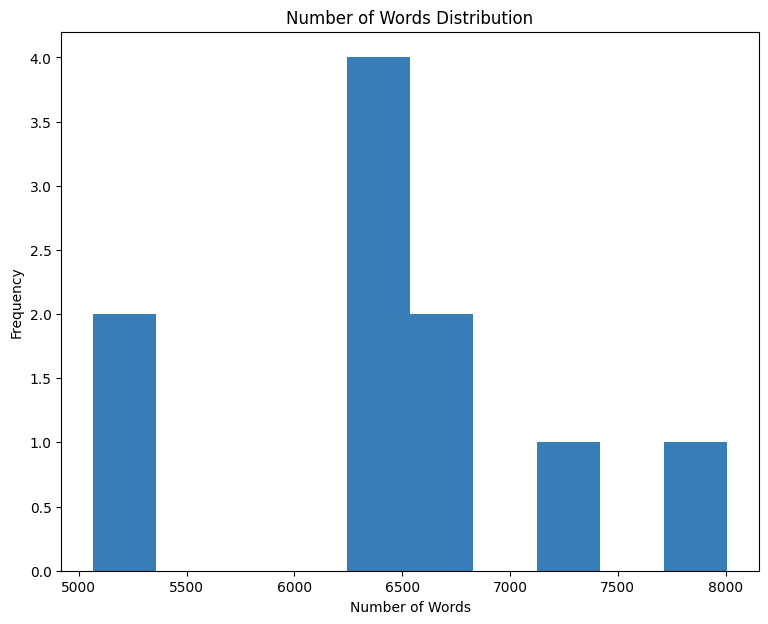

In [27]:
speaker_word_counts_iter2, speaker_mentions_of_iter2, speaker_utterances_iter2 = count_words_per_speaker(
    pdf_files=iter2_pdf_files,
    speakers=participant_text_names_iter2 + leaders_iter2
)

##### Check Transcript Words Distribution for Iteration 3


Number of documents: 12
Mean number of words per document: 8539.50
Standard deviation of number of words per document: 695.26


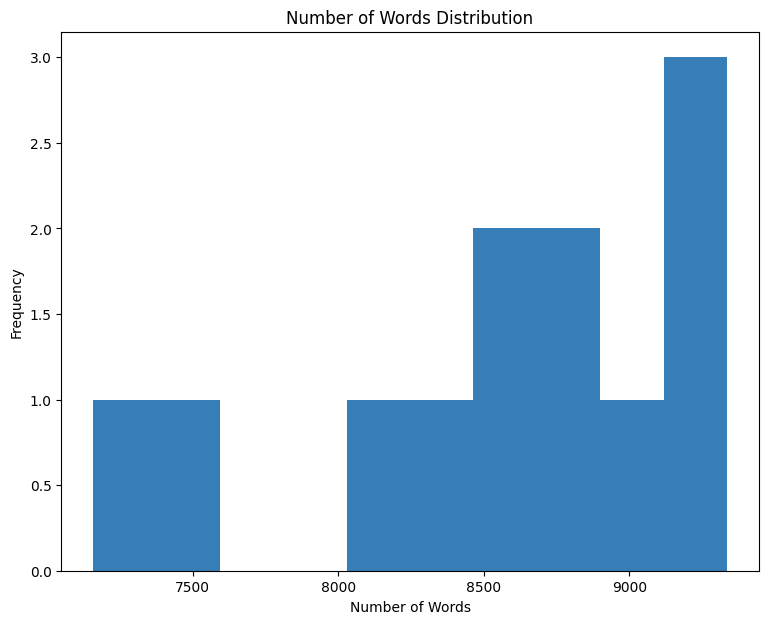

In [28]:
speaker_word_counts_iter3, speaker_mentions_of_iter3, speaker_utterances_iter3 = count_words_per_speaker(
    pdf_files=iter3_pdf_files,
    speakers=participants_iter3 + leaders_iter3
)

##### Define Function to Differentiate between Participants and Leaders

In [29]:
def add_leader_tag(d, leaders):
    d_plot = {}
    for k, v in d.items():
        if k in leaders:
            d_plot[k + " - Leader"] = v
        else:
            d_plot[k] = v

    return d_plot

##### Define Functions to Plot Speak Words, Mentions, and Utterances

In [30]:
def plot_total_words_per_speaker(speaker_word_counts, leaders):
    
    speaker_word_counts = add_leader_tag(speaker_word_counts, leaders)
    speaker_word_counts = dict(sorted(speaker_word_counts.items(), key=lambda item: item[1]))
    plt.barh(list(speaker_word_counts.keys()), speaker_word_counts.values())
    plt.title("Words Spoken by Each Speaker Across Sessions")
    plt.xlabel("Speaker")
    plt.ylabel("Number of Words")
    plt.show()
    
    
def plot_speaker_mentions_of_other_speakers(speaker_mentions_of, leaders):
    
    speaker_dict = {k + " - Speaker": v for k, v in speaker_mentions_of.items()}
    speaker_dict = add_leader_tag(speaker_dict, [l + " - Speaker" for l in leaders])
    speaker_matrix = pd.DataFrame(speaker_dict).T.fillna(0)
    sb.heatmap(speaker_matrix)
    plt.xlabel("Mentioned by Name")
    plt.ylabel("Speaker")
    plt.title("Count of Speaker Mentions by Name")
    plt.show()
    

def plot_num_utterances_per_speaker_per_session(speaker_utterances, leaders):
    
    # Create plot
    fig, ax = plt.subplots()
    for key in speaker_utterances:
        x = list(speaker_utterances[key].keys())
        y = [len(speaker_utterances[key][i]) for i in x]

        if key in leaders:
            label = key + " - Leader"
        else:
            label = key

        ax.plot(x, y, label=label)

    # Set plot title and axis labels
    ax.set_title("Number of Utterances per Session per Speaker")
    ax.set_xlabel("Session Number")
    ax.set_ylabel("Number of Utterances")

    # Set legend
    ax.legend(fontsize=6, loc="best")

    # Show plot
    plt.show()
    
def plot_num_words_per_speaker_per_session(speaker_utterances, leaders):
    
    # Create plot
    fig, ax = plt.subplots()
    for key in speaker_utterances:
        x = list(speaker_utterances[key].keys())
        y = [
            sum([len(utterance.split()) for utterance in speaker_utterances[key][i]])
            for i in x
        ]

        if key in leaders:
            label = key + " - Leader"
        else:
            label = key

        ax.plot(x, y, label=label)

    # Set plot title and axis labels
    ax.set_title("Number of Words per Session per Speaker")
    ax.set_xlabel("Session Number")
    ax.set_ylabel("Number of Words")

    # Set legend
    ax.legend(fontsize=6, loc="best")

    # Show plot
    plt.show()

##### View Graphical Summaries of Iteration 2

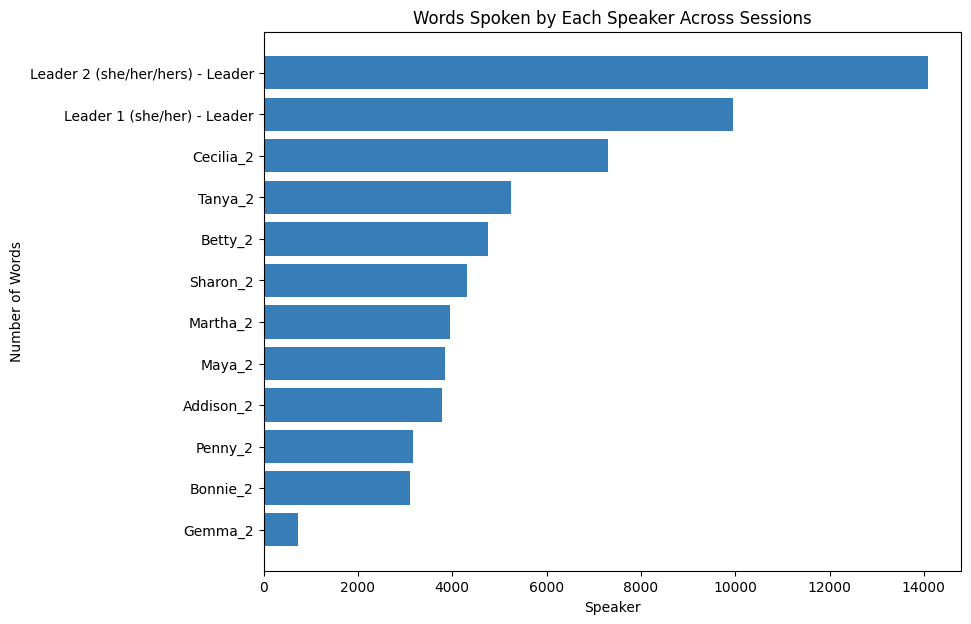

In [31]:
plot_total_words_per_speaker(speaker_word_counts_iter2, leaders_iter2)

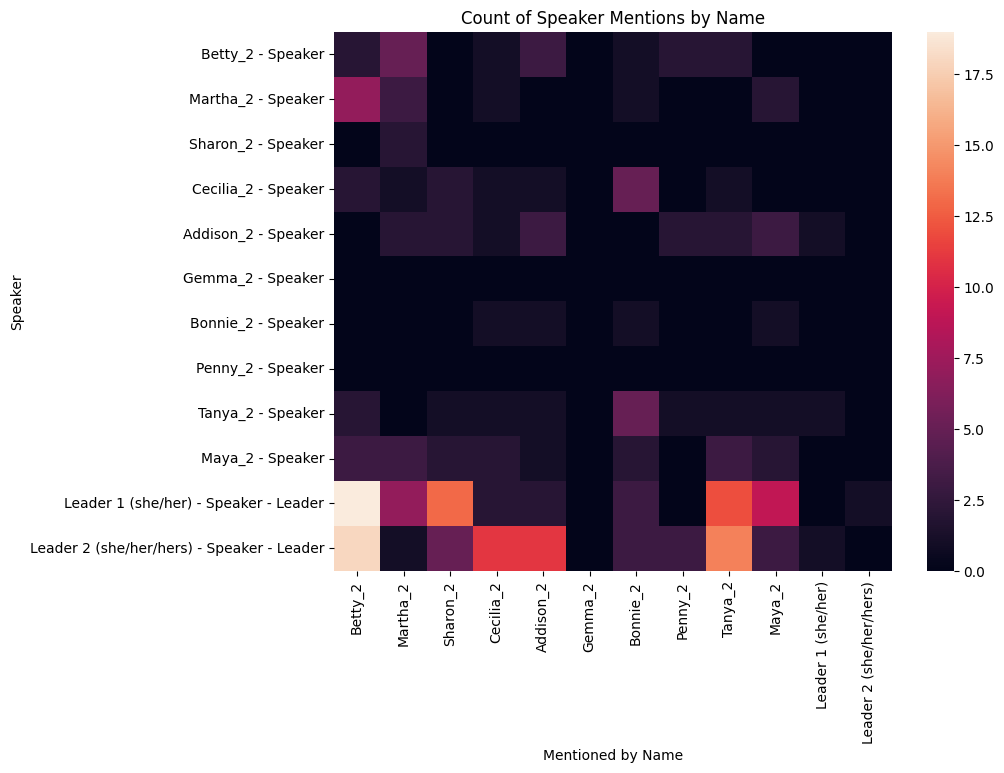

In [32]:
plot_speaker_mentions_of_other_speakers(speaker_mentions_of_iter2, leaders_iter2)

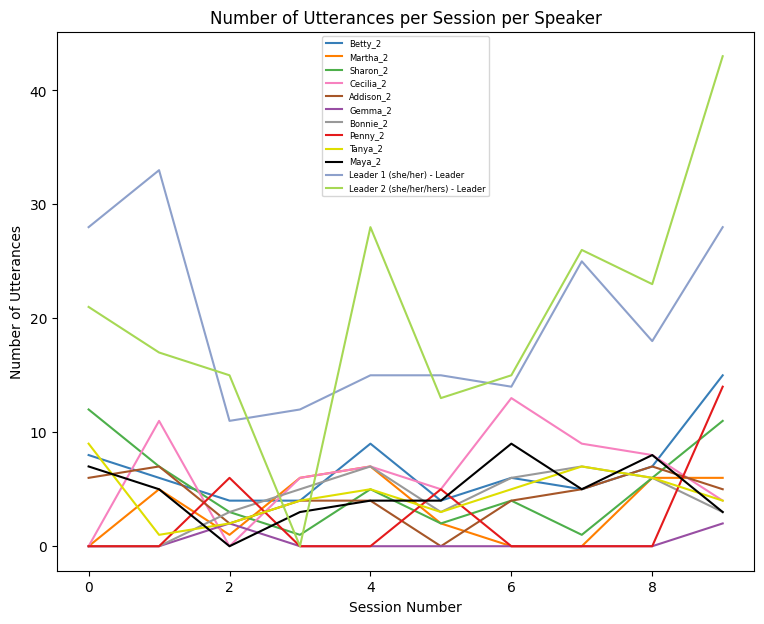

In [33]:
plot_num_utterances_per_speaker_per_session(speaker_utterances_iter2, leaders_iter2)

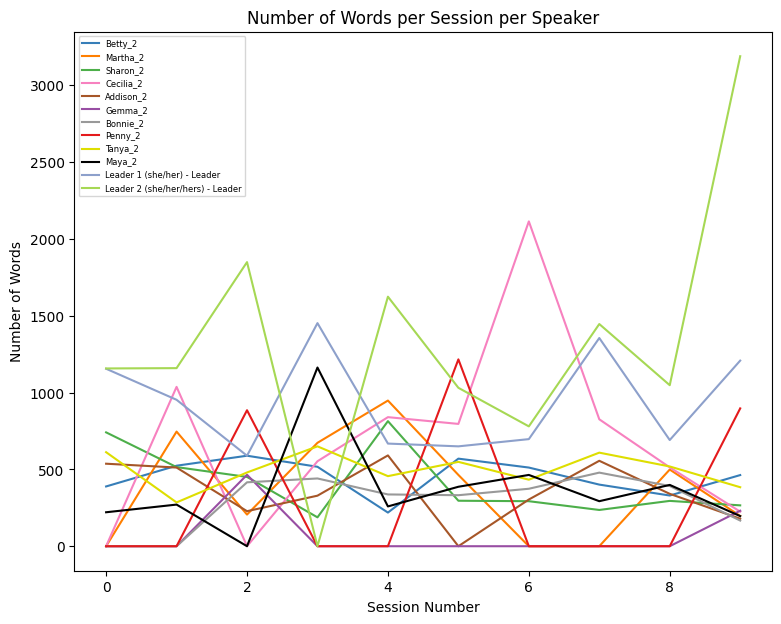

In [34]:
plot_num_words_per_speaker_per_session(speaker_utterances_iter2, leaders_iter2)

##### View Graphical Summaries of Iteration 3

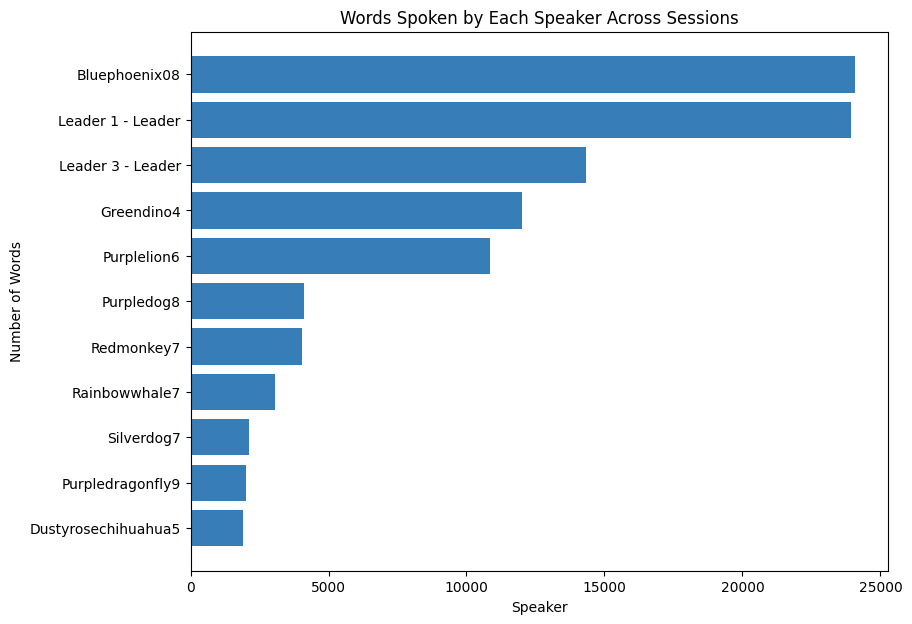

In [35]:
plot_total_words_per_speaker(speaker_word_counts_iter3, leaders_iter3)

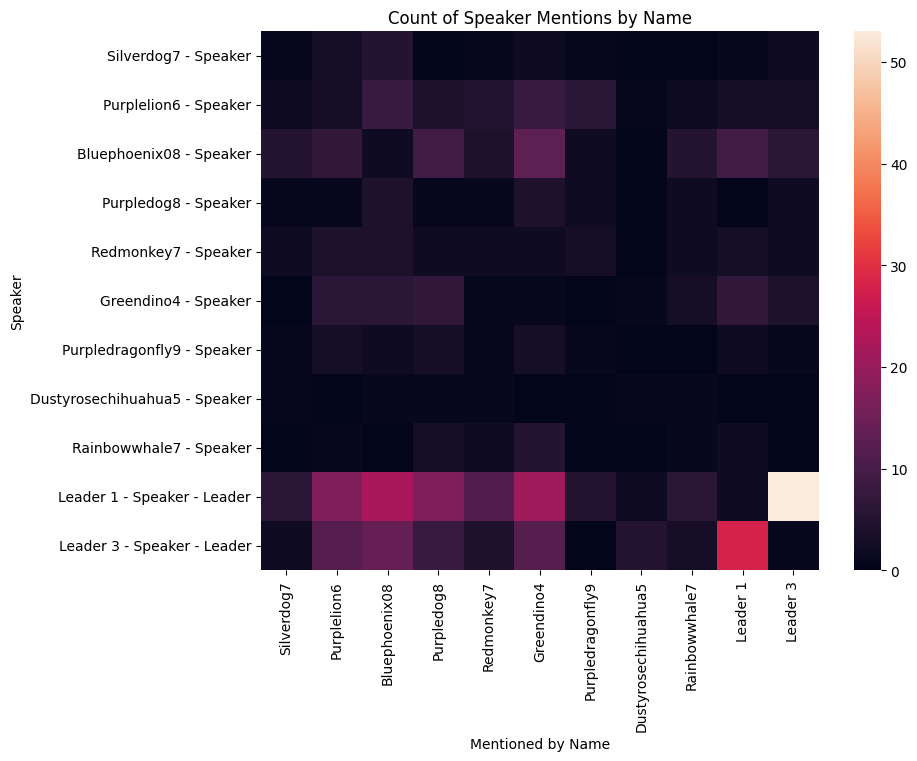

In [36]:
plot_speaker_mentions_of_other_speakers(speaker_mentions_of_iter3, leaders_iter3)

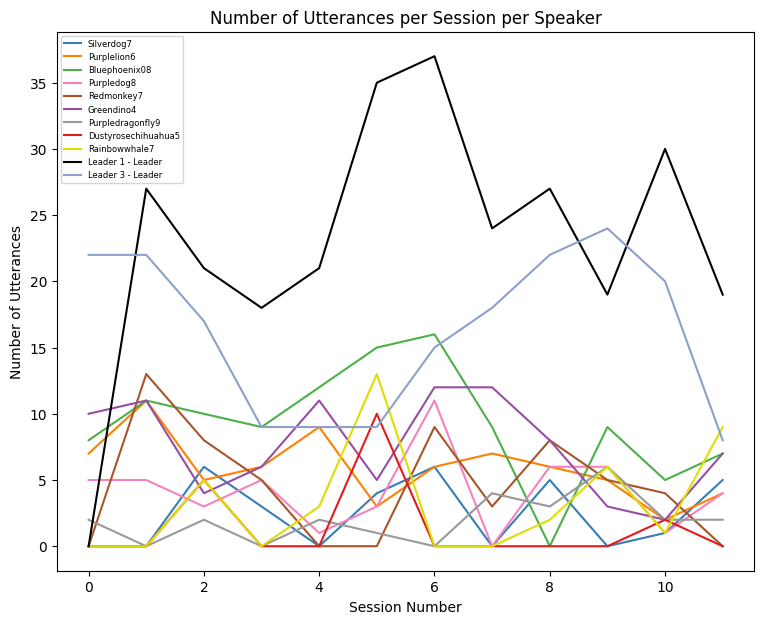

In [37]:
plot_num_utterances_per_speaker_per_session(speaker_utterances_iter3, leaders_iter3)

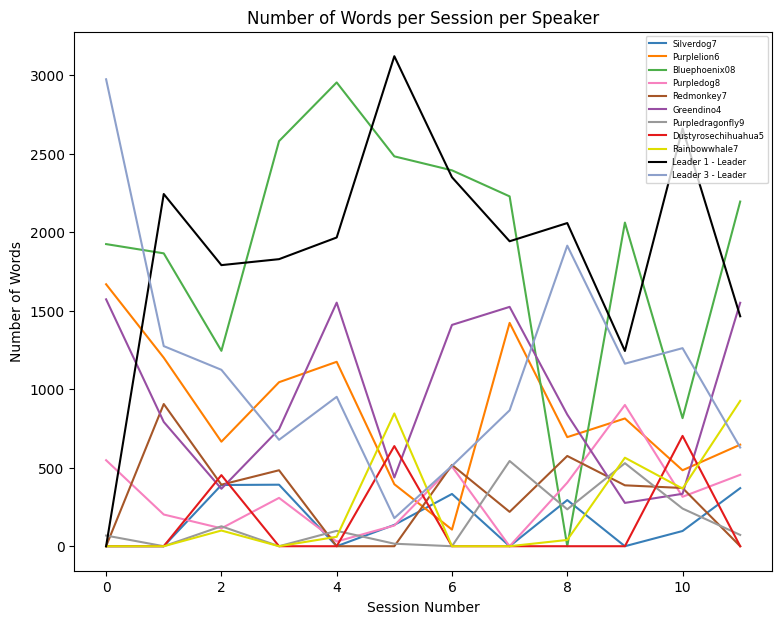

In [38]:
plot_num_words_per_speaker_per_session(speaker_utterances_iter3, leaders_iter3)

##### Define Function to Compute Normalized Emotion Scores Over All Utterances in Each Session

In [39]:
def compute_emotion_scores(speaker_utterances, emotions):

    xs = []
    ys = []
    for key in speaker_utterances:
        x = list(speaker_utterances[key].keys())
        y = {emotion: [] for emotion in emotions}

        for i in x:
            # Iterate through utterances to obtain emotion scores
            word_count = 0
            emotion_scores = {emotion: [] for emotion in emotions}
            for utterance in speaker_utterances[key][i]:
                # Compute utterance length in words
                utterance_length = len(utterance.split())
                word_count += utterance_length

                # Compute sentiment
                # To reduce runtime, run inference over batched utterances
                output = sent_pipeline(utterance)[0]

                # Save normalized emotion scores
                for d in output:
                    # Compute the normalized emotion score
                    emotion_scores[d["label"]].append(d["score"] * utterance_length)

            # Add the scaled emotion score for the emotion of interest
            for emotion in emotions:
                # Get the scores for the given emotion
                scores = emotion_scores[emotion]

                # Scale the scores
                if word_count == 0:
                    scaled_score = 0
                else:
                    scaled_score = sum(scores) / word_count

                # Save the scaled score
                y[emotion].append(scaled_score)

        xs.append(x)
        ys.append(y)
        
    
    return xs, ys

In [40]:
iter2_xs, iter2_ys = compute_emotion_scores(speaker_utterances=speaker_utterances_iter2, emotions=emotions)
iter3_xs, iter3_ys = compute_emotion_scores(speaker_utterances=speaker_utterances_iter3, emotions=emotions)

##### Define Function to Plot Trend for a Given Emotion

In [41]:
def plot_emotion_trend(emotion, speaker_utterances, xs, ys, leaders):
    # Create plot
    fig, ax = plt.subplots()

    # Iterate through sessions
    for key, x, y in zip(speaker_utterances, xs, ys):
        if key in leaders:
            label = key + " - Leader"
        else:
            label = key

        # Plot emotion scores for the session for the given participant
        ax.plot(x, y[emotion], label=label)

    # Set plot title and axis labels
    ax.set_title(f"Score for Emotion: {emotion}")
    ax.set_xlabel("Session Number")
    ax.set_ylabel("Session Emotion Score Normalized by Utterance Lengths")

    # Set legend
    ax.legend(fontsize=6, loc="best")

    # Show plot
    plt.show()

##### Plot all Emotion Trends for Iteration 2

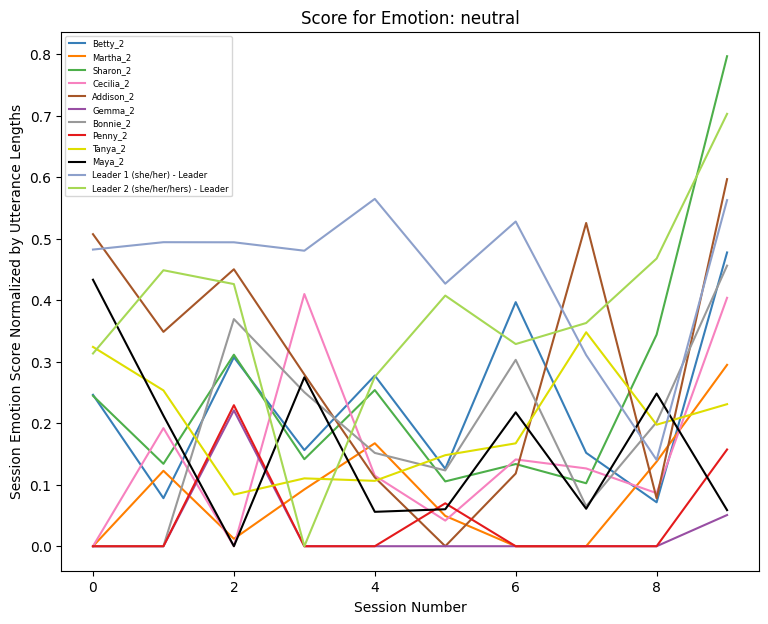

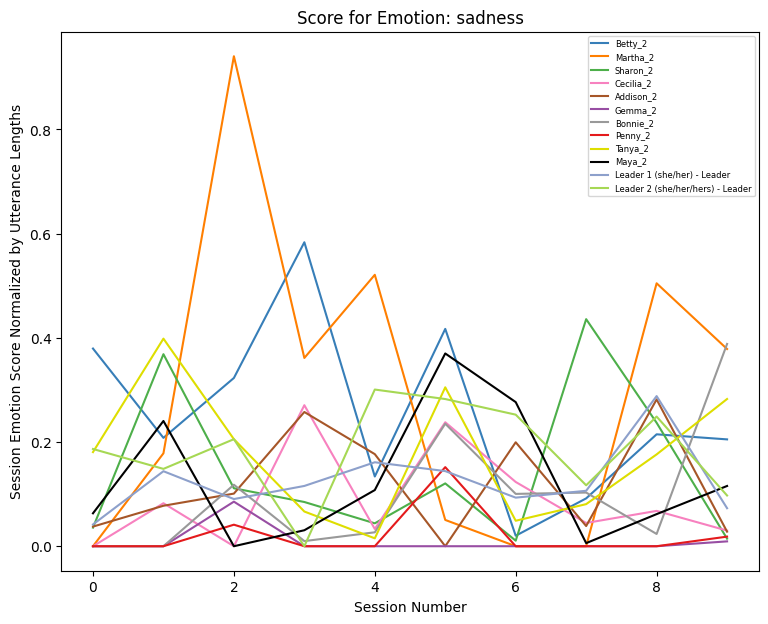

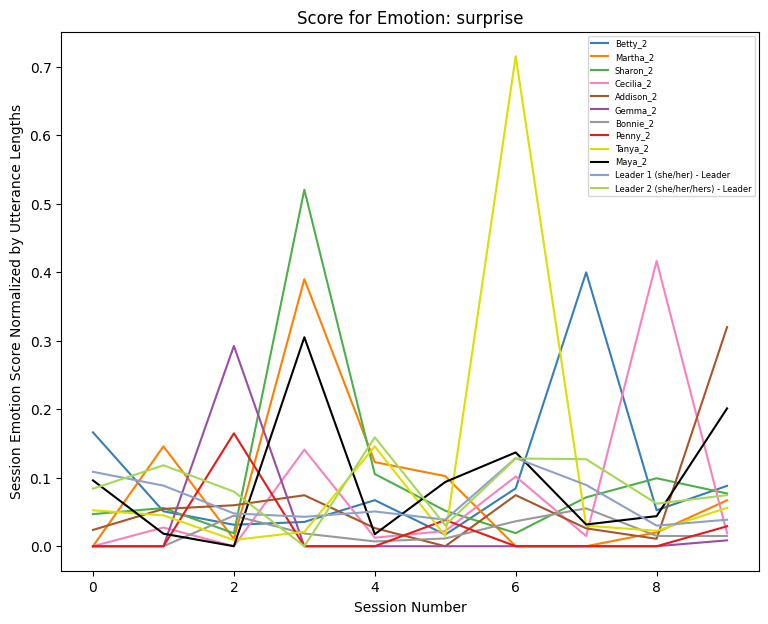

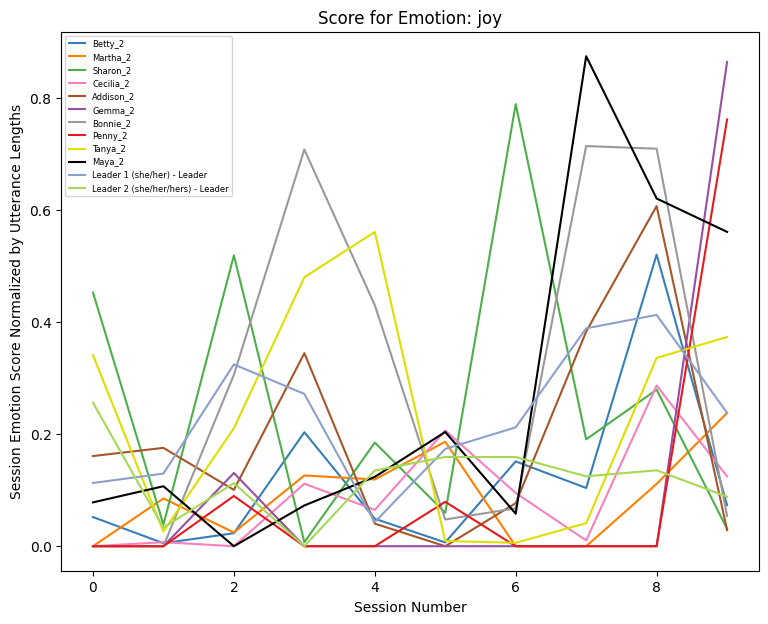

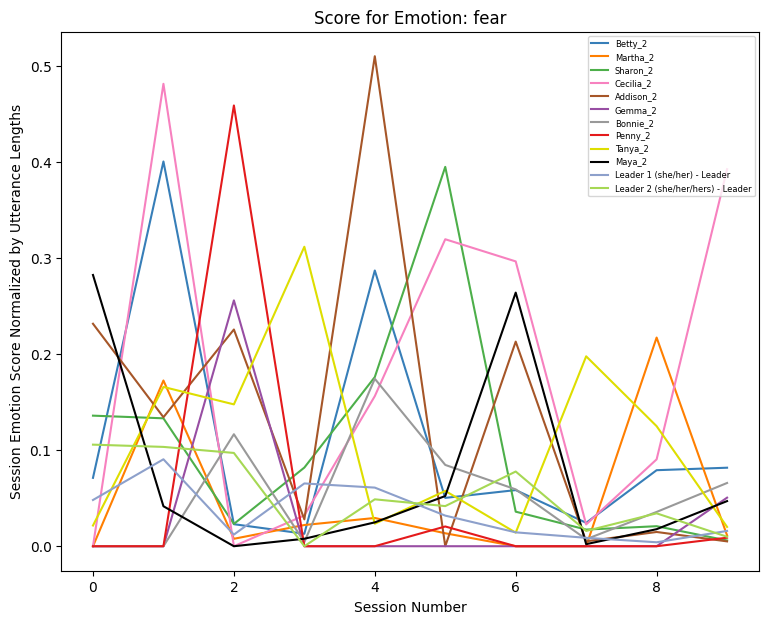

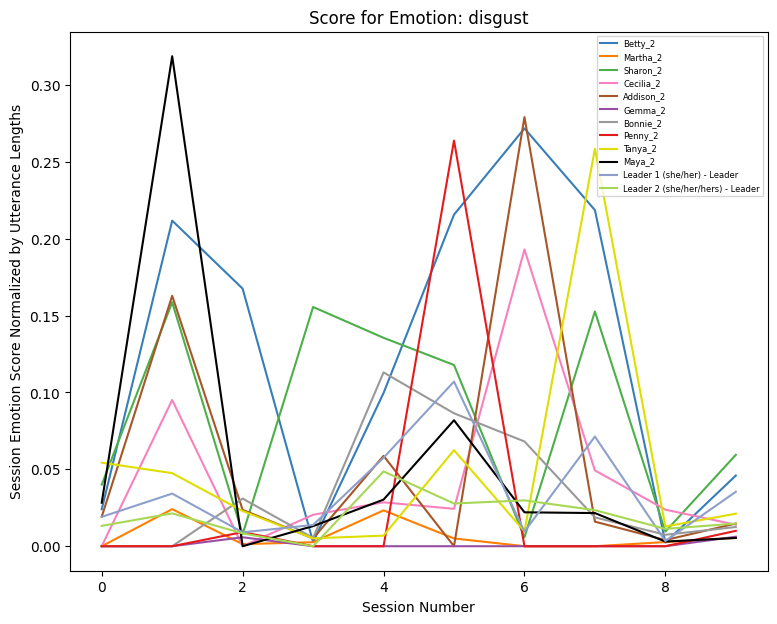

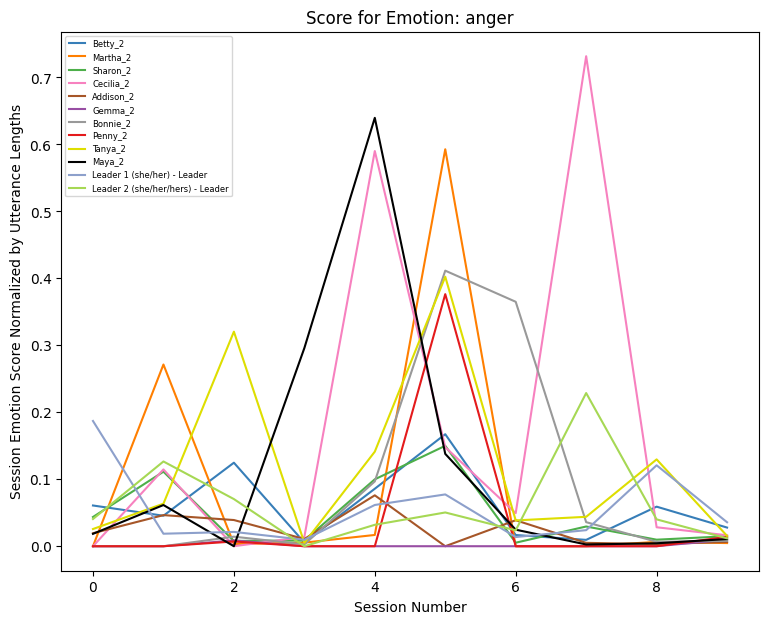

In [42]:
for emotion in emotions:
    plot_emotion_trend(
        emotion,
        speaker_utterances=speaker_utterances_iter2,
        xs=iter2_xs,
        ys=iter2_ys,
        leaders=leaders_iter2
    )

##### Plot all Emotion Trends for Iteration 3

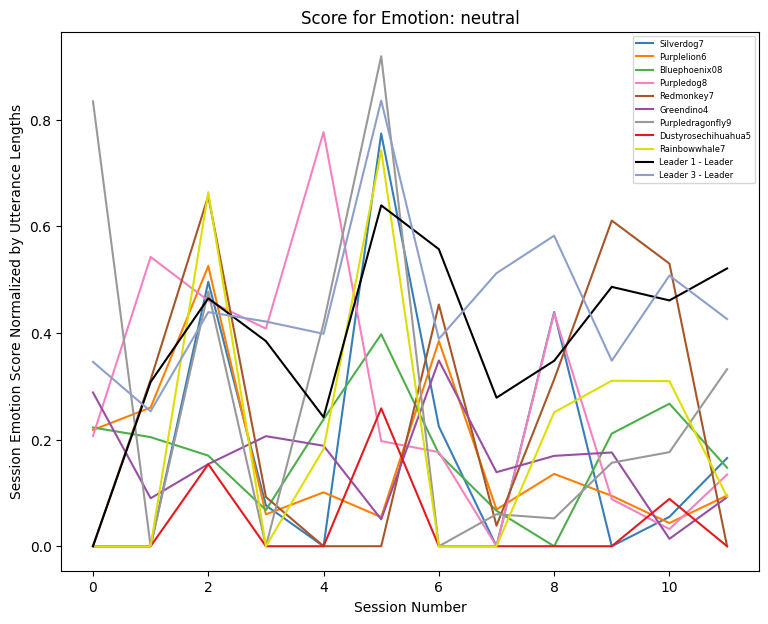

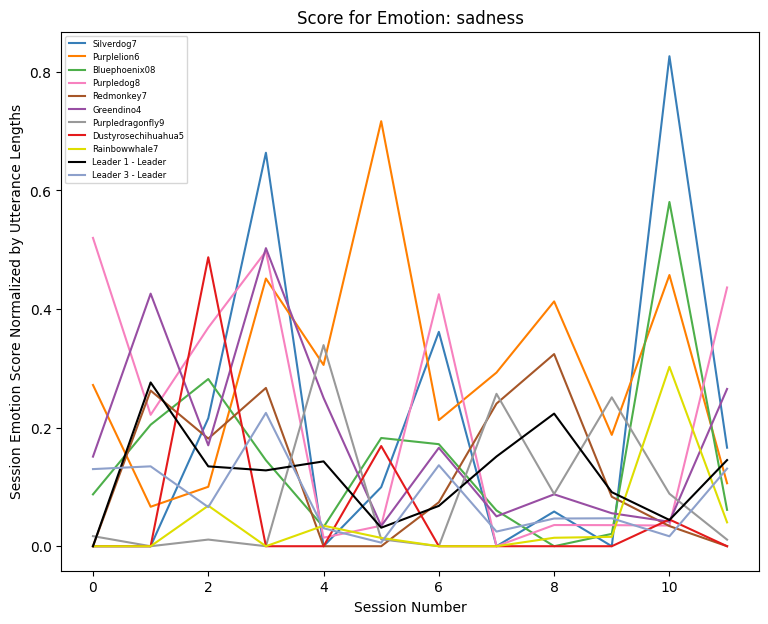

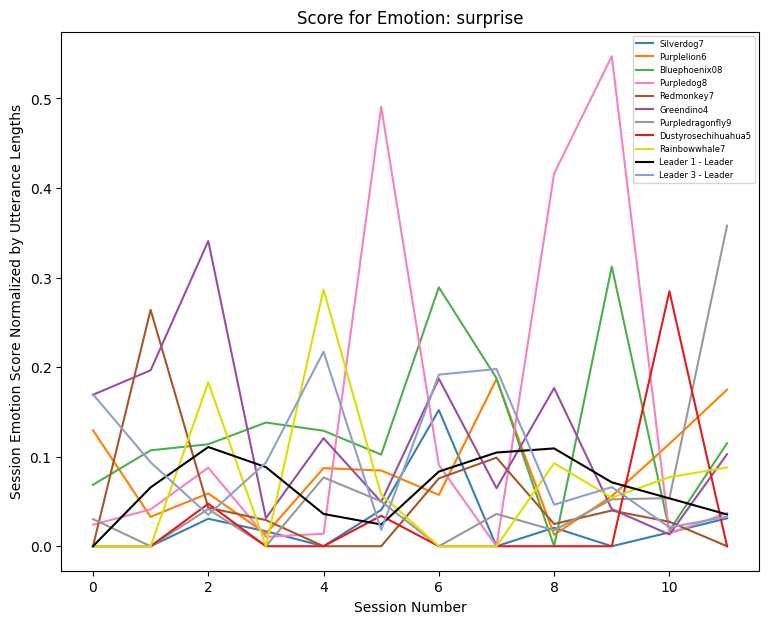

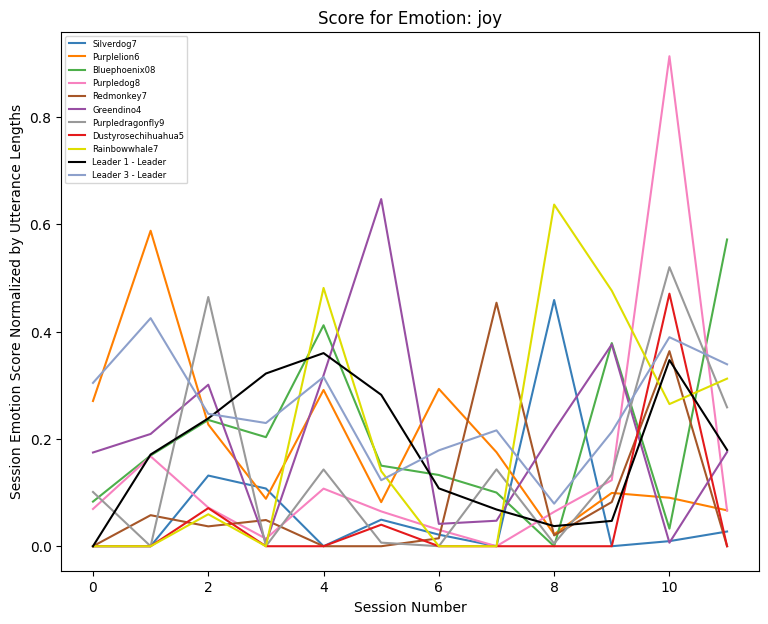

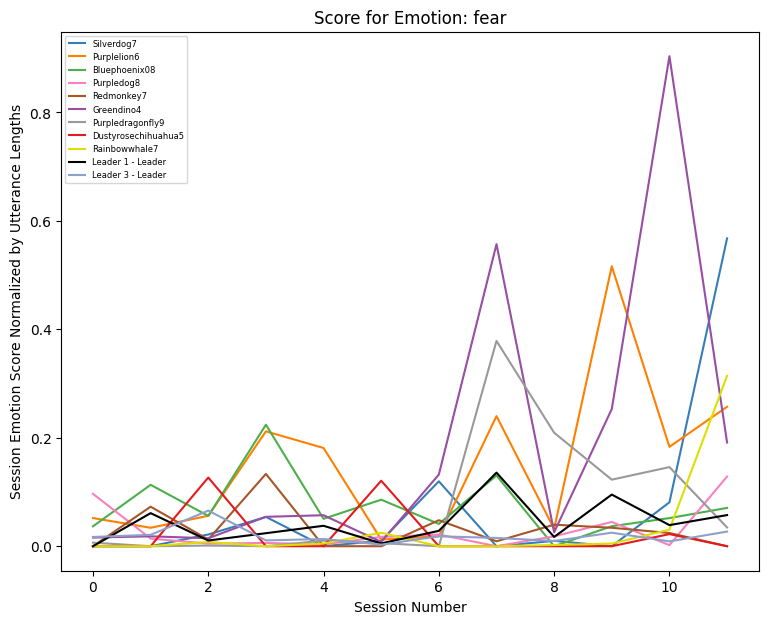

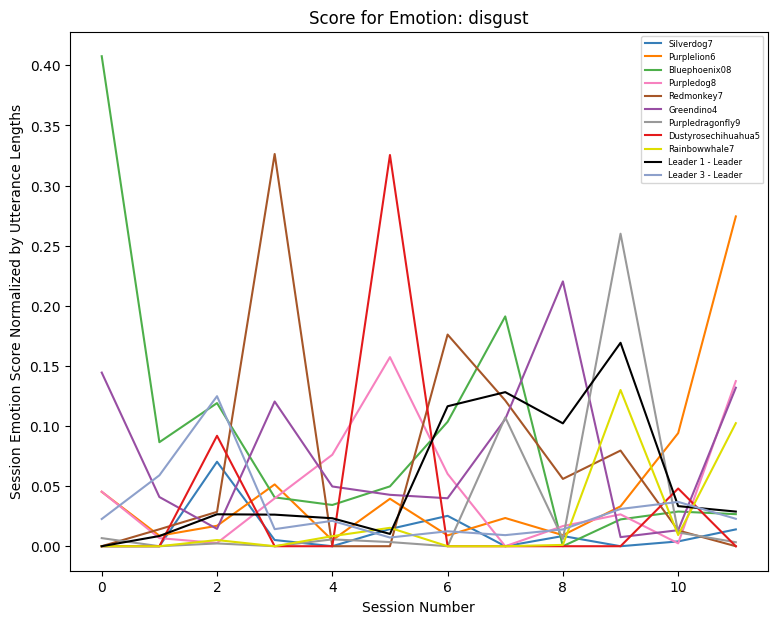

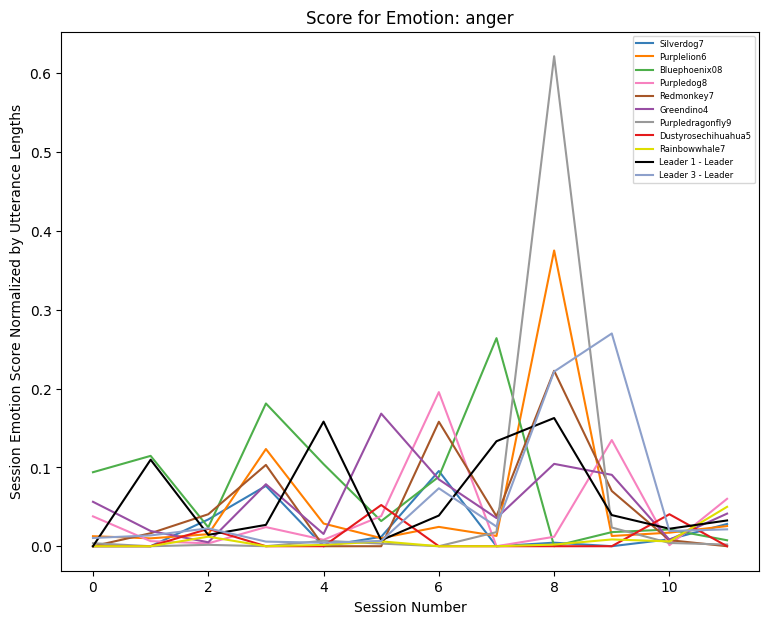

In [43]:
for emotion in emotions:
    plot_emotion_trend(
        emotion,
        speaker_utterances=speaker_utterances_iter3,
        xs=iter3_xs,
        ys=iter3_ys,
        leaders=leaders_iter3
    )